# Part 4: Self-Attention from Scratch
## The heart of the transformer

In Parts 1-3, our model processed context like this:

```
Input: [token_1, token_2, token_3, token_4, token_5]
         ↓        ↓        ↓        ↓        ↓
      [emb_1,   emb_2,   emb_3,   emb_4,   emb_5]
         ↓        ↓        ↓        ↓        ↓
      [              FLATTEN                    ]
         ↓
      [         SINGLE HIDDEN LAYER            ]
         ↓
      [              OUTPUT                     ]
```

**The problem**: Every position is treated identically. The model can't dynamically focus on relevant tokens.

## Enter Attention

Attention lets each position **look at and weight other positions** based on relevance:

```
"The cat sat on the mat"
          ↓
When predicting after "mat", attention might:
- Focus heavily on "cat" (the subject)
- Focus on "sat" (the verb)
- Ignore "the" (low information)
```

## Setup

In [38]:
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
import math
import os
import requests

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

%config InlineBackend.figure_format = 'retina'


Using device: cuda


In [39]:
# Load data
if not os.path.exists('shakespeare.txt'):
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    response = requests.get(url)
    with open('shakespeare.txt', 'w') as f:
        f.write(response.text)

with open('shakespeare.txt', 'r') as f:
    text = f.read()

chars = sorted(set(text))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(stoi)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 65


## Step 1: Understanding Attention Mathematically

Attention computes a weighted combination of values, where weights are based on query-key similarity.

**Formula**:
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V$$

Where:
- **Q** (Query): What am I looking for?
- **K** (Key): What do I contain?
- **V** (Value): What information do I provide?

In [40]:
def simple_attention(query, key, value):
    """
    Basic attention mechanism.
    
    Args:
        query: [batch, seq_len, d_k]
        key: [batch, seq_len, d_k]
        value: [batch, seq_len, d_v]
    
    Returns:
        output: [batch, seq_len, d_v]
        attention_weights: [batch, seq_len, seq_len]
    """
    d_k = query.shape[-1]
    
    # Step 1: Compute attention scores (how much each position attends to each other)
    # [batch, seq_len, d_k] @ [batch, d_k, seq_len] = [batch, seq_len, seq_len]
    scores = torch.matmul(query, key.transpose(-2, -1))
    
    # Step 2: Scale by sqrt(d_k) to prevent softmax saturation
    scores = scores / math.sqrt(d_k)
    
    # Step 3: Softmax to get attention weights (sum to 1)
    attention_weights = F.softmax(scores, dim=-1)
    
    # Step 4: Weighted sum of values
    output = torch.matmul(attention_weights, value)
    
    return output, attention_weights

In [41]:
# Example: 3 tokens, embedding dim 4
seq_len = 3
d_model = 4

# Random embeddings (pretend these represent "The cat sat")
embeddings = torch.randn(1, seq_len, d_model)

# In self-attention, Q, K, V all come from the same input
Q = embeddings
K = embeddings
V = embeddings

output, weights = simple_attention(Q, K, V)

print(f"Input shape: {embeddings.shape}")
print(f"Output shape: {output.shape}")
print(f"\nAttention weights (who attends to whom):")
print(weights.squeeze().numpy().round(3))

Input shape: torch.Size([1, 3, 4])
Output shape: torch.Size([1, 3, 4])

Attention weights (who attends to whom):
[[0.332 0.29  0.378]
 [0.034 0.93  0.036]
 [0.307 0.251 0.442]]


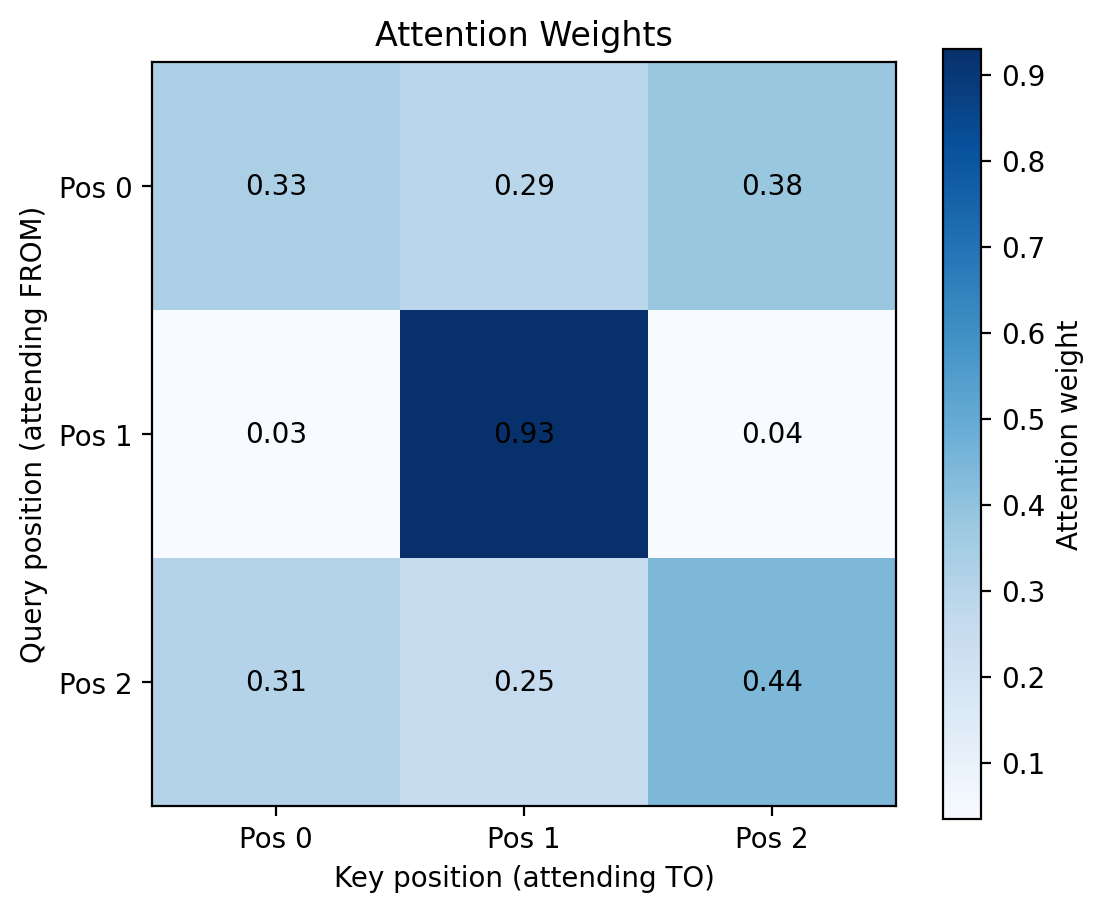

In [42]:
# Visualize attention weights
plt.figure(figsize=(6, 5))
plt.imshow(weights.squeeze().numpy(), cmap='Blues')
plt.colorbar(label='Attention weight')
plt.xlabel('Key position (attending TO)')
plt.ylabel('Query position (attending FROM)')
plt.title('Attention Weights')
positions = ['Pos 0', 'Pos 1', 'Pos 2']
plt.xticks(range(3), positions)
plt.yticks(range(3), positions)
for i in range(3):
    for j in range(3):
        plt.text(j, i, f'{weights[0, i, j]:.2f}', ha='center', va='center')
plt.show()

## Step 2: Causal (Masked) Attention

For language modeling, we can only attend to **past** positions (can't peek at future tokens!).

In [43]:
def causal_attention(query, key, value):
    """
    Causal (masked) attention - can only attend to past positions.
    """
    d_k = query.shape[-1]
    seq_len = query.shape[1]
    
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    # Create causal mask: upper triangle = -inf (can't attend to future)
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
    scores = scores.masked_fill(mask, float('-inf'))
    
    attention_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attention_weights, value)
    
    return output, attention_weights

# Test causal attention
output_causal, weights_causal = causal_attention(Q, K, V)
print("Causal attention weights:")
print(weights_causal.squeeze().numpy().round(3))

Causal attention weights:
[[1.    0.    0.   ]
 [0.035 0.965 0.   ]
 [0.307 0.251 0.442]]


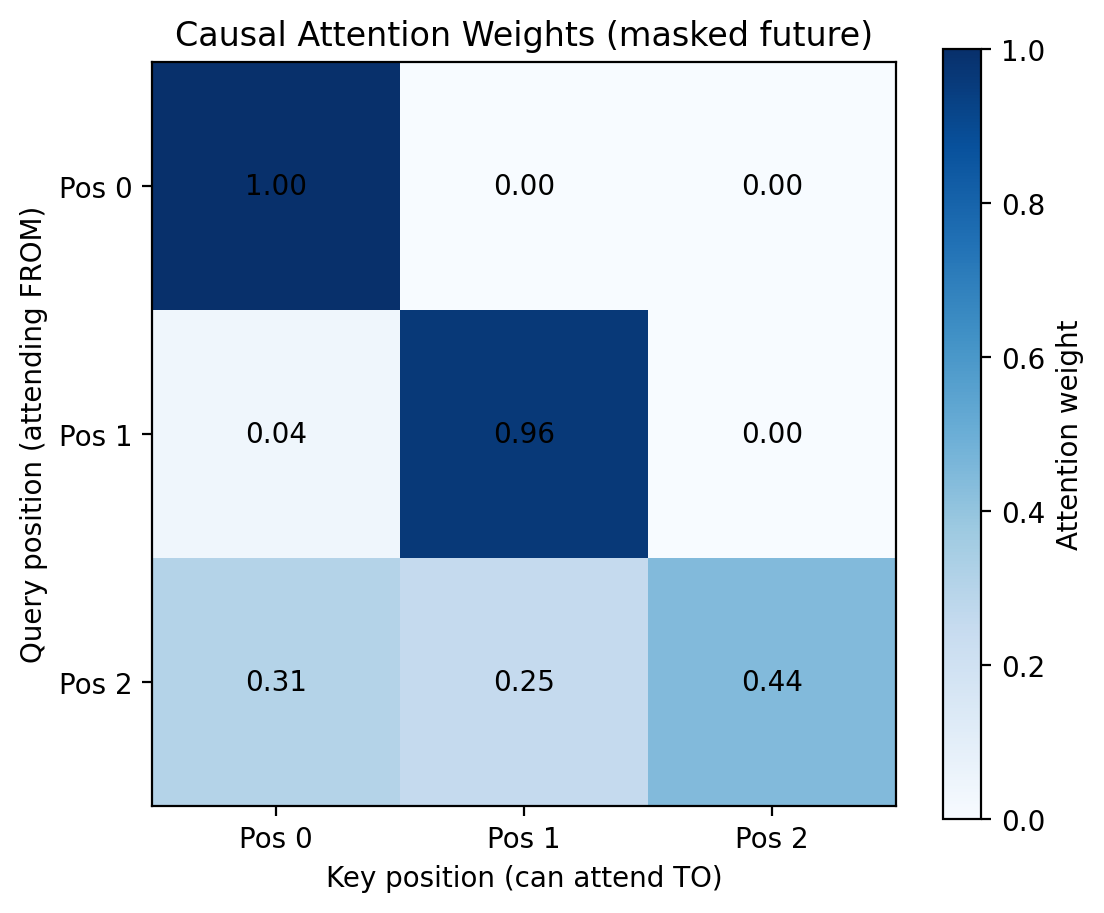

In [44]:
# Visualize causal mask
plt.figure(figsize=(6, 5))
plt.imshow(weights_causal.squeeze().numpy(), cmap='Blues')
plt.colorbar(label='Attention weight')
plt.xlabel('Key position (can attend TO)')
plt.ylabel('Query position (attending FROM)')
plt.title('Causal Attention Weights (masked future)')
plt.xticks(range(3), ['Pos 0', 'Pos 1', 'Pos 2'])
plt.yticks(range(3), ['Pos 0', 'Pos 1', 'Pos 2'])
for i in range(3):
    for j in range(3):
        plt.text(j, i, f'{weights_causal[0, i, j]:.2f}', ha='center', va='center')
plt.show()

Notice:
- Position 0 can only attend to itself (weight = 1.0)
- Position 1 attends to positions 0 and 1
- Position 2 attends to all positions 0, 1, 2
- No position attends to the future!

## Step 3: Self-Attention Layer

In practice, we learn separate projections for Q, K, V:

In [45]:
class SelfAttention(nn.Module):
    """
    Self-attention layer with learned projections.
    """
    
    def __init__(self, d_model, d_k=None):
        super().__init__()
        if d_k is None:
            d_k = d_model
        
        # Learned projections
        self.W_q = nn.Linear(d_model, d_k, bias=False)
        self.W_k = nn.Linear(d_model, d_k, bias=False)
        self.W_v = nn.Linear(d_model, d_k, bias=False)
        self.d_k = d_k
    
    def forward(self, x, mask=True):
        """
        Args:
            x: [batch, seq_len, d_model]
            mask: Whether to apply causal mask
        
        Returns:
            output: [batch, seq_len, d_k]
        """
        # Project to Q, K, V
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        # Compute attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply causal mask if needed
        if mask:
            seq_len = x.shape[1]
            causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
            scores = scores.masked_fill(causal_mask, float('-inf'))
        
        # Softmax and weighted sum
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        
        return output

## Step 4: Multi-Head Attention

Instead of one attention, we compute multiple "heads" in parallel. Each head can learn different patterns:

- Head 1: Learn syntactic relationships
- Head 2: Learn semantic relationships
- Head 3: Learn positional patterns
- etc.

In [46]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention: multiple attention heads in parallel.
    """
    
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        # Combined projections for efficiency
        self.W_qkv = nn.Linear(d_model, 3 * d_model, bias=False)
        self.W_out = nn.Linear(d_model, d_model, bias=False)
    
    def forward(self, x, mask=True):
        batch, seq_len, d_model = x.shape
        
        # Project and split into Q, K, V
        qkv = self.W_qkv(x)  # [batch, seq_len, 3 * d_model]
        qkv = qkv.reshape(batch, seq_len, 3, self.n_heads, self.d_k)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, batch, n_heads, seq_len, d_k]
        Q, K, V = qkv[0], qkv[1], qkv[2]
        
        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Causal mask
        if mask:
            causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
            scores = scores.masked_fill(causal_mask, float('-inf'))
        
        attention = F.softmax(scores, dim=-1)
        output = torch.matmul(attention, V)
        
        # Combine heads
        output = output.permute(0, 2, 1, 3).reshape(batch, seq_len, d_model)
        output = self.W_out(output)
        
        return output

## Step 5: Positional Encoding

Attention is permutation-invariant—it doesn't know position! We add positional information:

In [47]:
class PositionalEncoding(nn.Module):
    """
    Sinusoidal positional encoding (from original Transformer paper).
    """
    
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        # Create positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer (not a parameter)
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        return x + self.pe[:, :x.shape[1]]

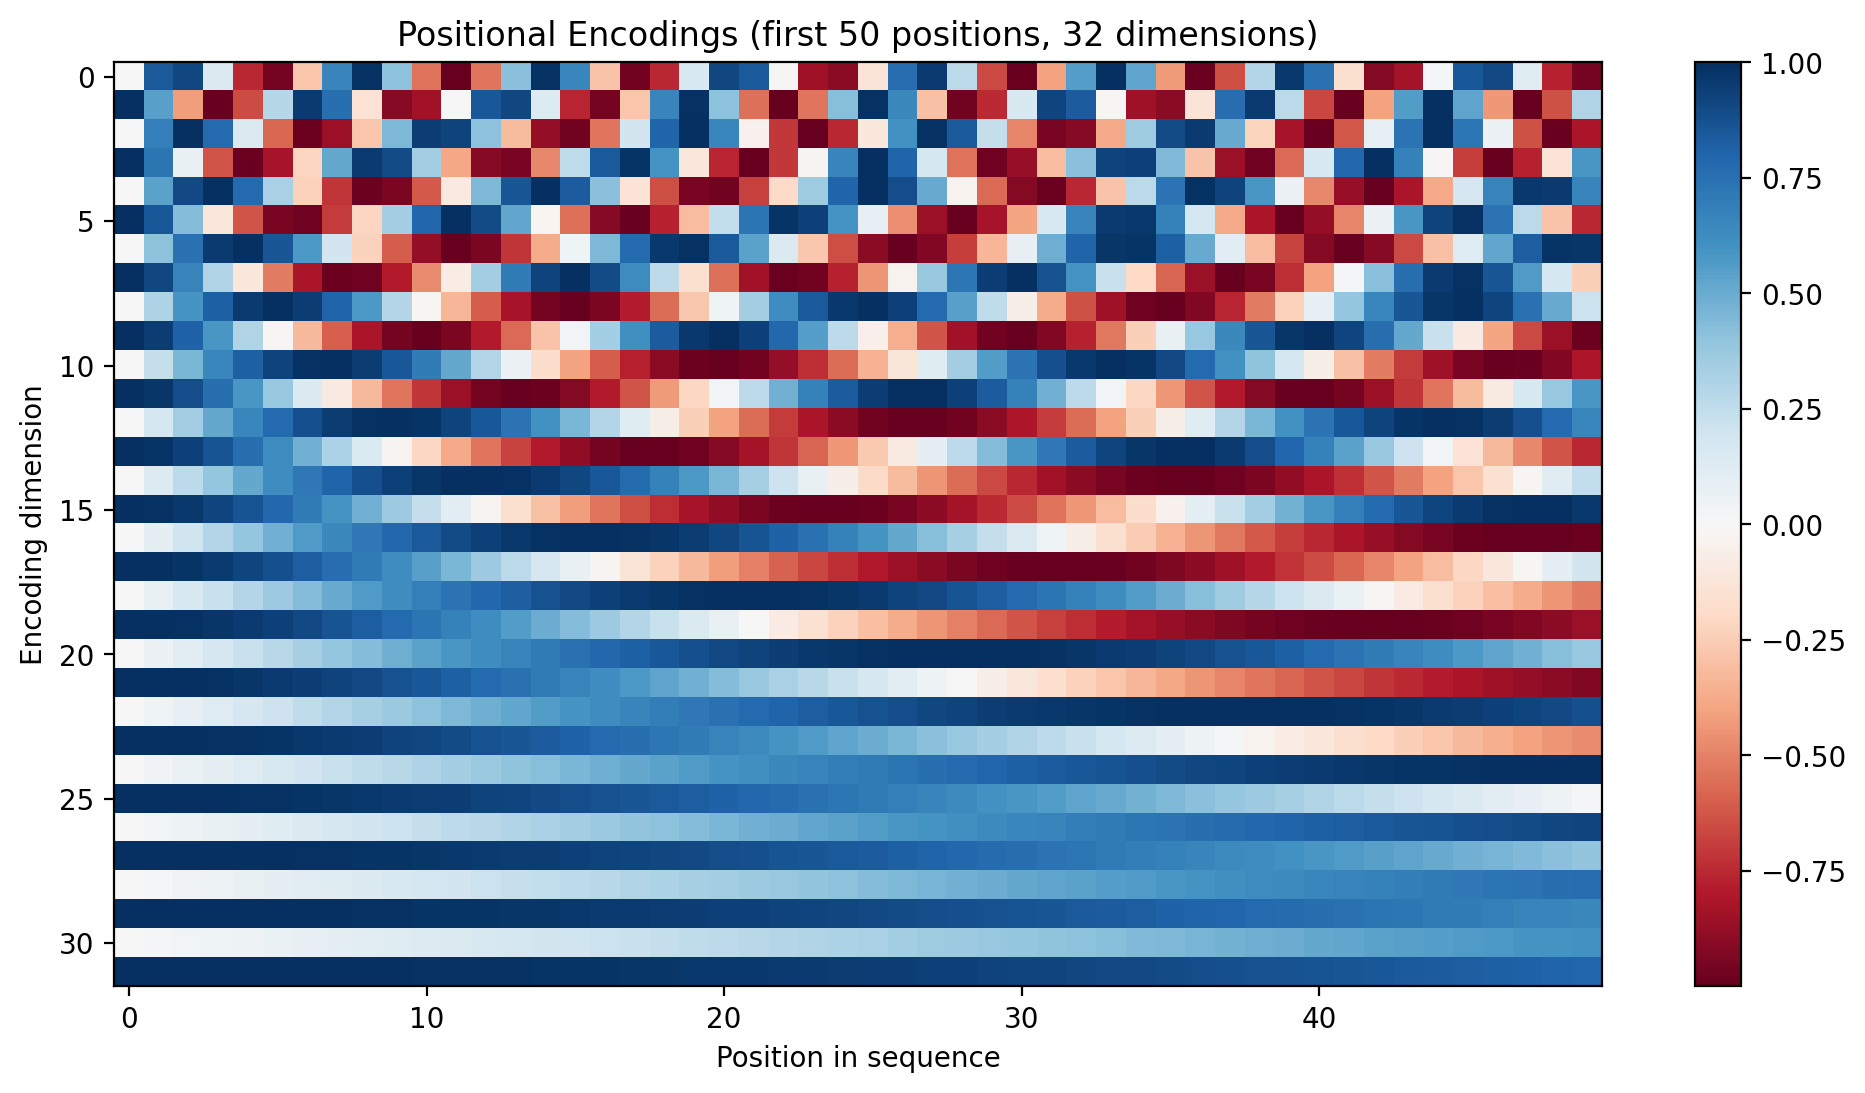

In [48]:
# Visualize positional encodings
pe = PositionalEncoding(64, 100)
encodings = pe.pe.squeeze().numpy()

plt.figure(figsize=(12, 6))
plt.imshow(encodings[:50, :32].T, aspect='auto', cmap='RdBu')
plt.colorbar()
plt.xlabel('Position in sequence')
plt.ylabel('Encoding dimension')
plt.title('Positional Encodings (first 50 positions, 32 dimensions)')
plt.show()

## Step 6: Transformer Block

A complete transformer block combines:
1. Multi-head attention
2. Feed-forward network
3. Residual connections
4. Layer normalization

In [49]:
class TransformerBlock(nn.Module):
    """
    A single transformer block.
    
    Architecture:
        x → LayerNorm → MultiHeadAttention → + (residual)
        → LayerNorm → FFN → + (residual)
    """
    
    def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1):
        super().__init__()
        
        if d_ff is None:
            d_ff = 4 * d_model
        
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Attention with residual
        x = x + self.dropout(self.attention(self.ln1(x)))
        
        # FFN with residual
        x = x + self.ffn(self.ln2(x))
        
        return x

## Step 7: Complete Transformer Language Model

In [50]:
class TransformerLM(nn.Module):
    """
    A small transformer language model.
    """
    
    def __init__(self, vocab_size, d_model, n_heads, n_layers, block_size, dropout=0.1):
        super().__init__()
        
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, block_size)
        self.dropout = nn.Dropout(dropout)
        
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, dropout=dropout)
            for _ in range(n_layers)
        ])
        
        self.ln_final = nn.LayerNorm(d_model)
        self.output = nn.Linear(d_model, vocab_size)
        
        self.block_size = block_size
    
    def forward(self, x):
        # Token embeddings + positional encoding
        x = self.token_emb(x)
        x = self.pos_enc(x)
        x = self.dropout(x)
        
        # Transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Output projection
        x = self.ln_final(x)
        logits = self.output(x)
        
        return logits

In [51]:
# Create model with REDUCED size for fast educational demo
block_size = 64   # Reduced from 128
d_model = 128     # Reduced from 256
n_heads = 4       # Reduced from 8
n_layers = 3      # Reduced from 6

model = TransformerLM(
    vocab_size=vocab_size,
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers,
    block_size=block_size,
    dropout=0.1
).to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {num_params:,}")
print(f"\nArchitecture:")
print(f"  Embedding dim: {d_model}")
print(f"  Attention heads: {n_heads}")
print(f"  Layers: {n_layers}")
print(f"  Block size: {block_size}")

# Model scale context
print(f"\n--- Model Scale Context ---")
print(f"Our model:     ~{num_params/1_000_000:.1f}M parameters (SMALL for fast demo!)")
print(f"GPT-2 Small:   124M parameters  ({124_000_000/num_params:.0f}x larger)")
print(f"GPT-3:         175B parameters  ({175_000_000_000/num_params:.0f}x larger)")
print(f"Claude/GPT-4:  ~1T+ parameters  ({1_000_000_000_000/num_params:.0f}x larger)")

Model parameters: 610,241

Architecture:
  Embedding dim: 128
  Attention heads: 4
  Layers: 3
  Block size: 64

--- Model Scale Context ---
Our model:     ~0.6M parameters (SMALL for fast demo!)
GPT-2 Small:   124M parameters  (203x larger)
GPT-3:         175B parameters  (286772x larger)
Claude/GPT-4:  ~1T+ parameters  (1638697x larger)


## Step 8: Training

In [52]:
# Prepare data - USE SUBSET for faster training!
def build_dataset(text, block_size, stoi):
    data = [stoi[ch] for ch in text]
    X, Y = [], []
    for i in range(len(data) - block_size):
        X.append(data[i:i + block_size])
        Y.append(data[i + 1:i + block_size + 1])
    return torch.tensor(X), torch.tensor(Y)

# Use only first 100K characters for faster demo (full dataset is 1.1M chars)
text_subset = text[:100000]
X, Y = build_dataset(text_subset, block_size, stoi)
print(f"Dataset: {len(X):,} examples (using subset of Shakespeare for speed)")
print(f"Full dataset would be: 1,115,266 examples")

Dataset: 99,936 examples (using subset of Shakespeare for speed)
Full dataset would be: 1,115,266 examples


In [ ]:
def train(model, X, Y, epochs=500, batch_size=64, lr=3e-4, checkpoint_path='../models/checkpoint_part4.pt', resume=True):
    """
    Resumable training with checkpoint saving.
    
    Args:
        resume: If True, attempts to resume from checkpoint
        checkpoint_path: Path to save/load checkpoints
    """
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    
    X, Y = X.to(device), Y.to(device)
    losses = []
    start_epoch = 0
    
    # Try to resume from checkpoint
    if resume and os.path.exists(checkpoint_path):
        print(f"Resuming from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        losses = checkpoint['losses']
        print(f"Resumed from epoch {start_epoch}, previous loss: {losses[-1]:.4f}")
    
    for epoch in range(start_epoch, epochs):
        perm = torch.randperm(X.shape[0])
        total_loss, n_batches = 0, 0
        
        for i in range(0, len(X), batch_size):
            idx = perm[i:i+batch_size]
            x_batch, y_batch = X[idx], Y[idx]
            
            logits = model(x_batch)
            loss = F.cross_entropy(logits.view(-1, vocab_size), y_batch.view(-1))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            n_batches += 1
        
        losses.append(total_loss / n_batches)
        
        # Print progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {losses[-1]:.4f}")
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'losses': losses,
            }, checkpoint_path)
    
    print(f"Training complete! Final loss: {losses[-1]:.4f}")
    return losses

# Educational note: Fast training for demo - 50 epochs on small model/dataset
# For production: use larger model (d_model=512+), full data, 1000+ epochs
# Training is resumable - interrupt and re-run this cell to continue!
print("Training transformer (small & fast for educational demo)...")
print("You can interrupt and resume training by re-running this cell!")
losses = train(model, X, Y, epochs=50, batch_size=128, lr=3e-4)

In [54]:
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transformer Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

NameError: name 'losses' is not defined

<Figure size 1000x400 with 0 Axes>

## Step 9: Generate Text

In [55]:
@torch.no_grad()
def generate(model, seed_text, max_len=500, temperature=0.8):
    model.eval()
    
    tokens = [stoi[ch] for ch in seed_text]
    generated = list(seed_text)
    
    for _ in range(max_len):
        # Take last block_size tokens
        context = tokens[-block_size:] if len(tokens) >= block_size else tokens
        x = torch.tensor([context]).to(device)
        
        logits = model(x)
        # Get prediction for last position
        logits = logits[0, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)
        next_idx = torch.multinomial(probs, 1).item()
        
        tokens.append(next_idx)
        generated.append(itos[next_idx])
    
    return ''.join(generated)

print("=" * 60)
print("GENERATED TEXT (Transformer)")
print("=" * 60)
print(generate(model, "ROMEO:\n", max_len=500))

GENERATED TEXT (Transformer)
ROMEO:
I would they were abed!

VOLUMNIA:
Is it not to stand upon't.

VOLUMNIA:
I have been, yet the state, who should his country.

First Citizen:
It was an enormity
A man-hild heard a shall against all
pot, dispatch of them. Is the senate poise know beatt.

MENENIUS:
O, me dire to crept that so prevail'd with flattter Neptune for his herd
As on harms that beheld--

MENENIUS:
In that sent to state of his obedience?
Our greater:
I'll repor in thee!

First Senator:
Speak, good Sien,
When, I have heart t


## Save Model for Later Use

Export the transformer model for use in Part 5 (instruction tuning) and beyond.

In [ ]:
import os

# Create models directory
os.makedirs('../models', exist_ok=True)

# Save model checkpoint with architecture info
checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'vocab_size': vocab_size,
        'd_model': d_model,
        'n_heads': n_heads,
        'n_layers': n_layers,
        'block_size': block_size,
    },
    'stoi': stoi,
    'itos': itos,
    'final_loss': losses[-1] if losses else None,
}

torch.save(checkpoint, '../models/transformer_shakespeare.pt')
print(f"Model saved to ../models/transformer_shakespeare.pt")

# Verify
loaded = torch.load('../models/transformer_shakespeare.pt', weights_only=False)
print(f"Model config: {loaded['model_config']}")
print(f"Model parameters: {num_params:,}")

## Clean Up GPU Memory

In [ ]:
import gc

# Delete model and data tensors
del model
del X, Y

# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

gc.collect()

print("GPU memory cleared!")
if torch.cuda.is_available():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1024**2:.1f} MB")

## Comparing MLP vs Transformer

| Aspect | MLP (Part 1-3) | Transformer (Part 4) |
|--------|----------------|----------------------|
| Context processing | Flatten + FC | Self-attention |
| Position awareness | None (implicit) | Explicit encoding |
| Dynamic focus | No | Yes (attention) |
| Parallelization | Full | Full |
| Learns long-range | Difficult | Natural |
| Parameters (our models) | ~50K | ~400K |

## Summary

We built self-attention from scratch:

| Component | Purpose |
|-----------|---------|
| Q, K, V projections | Learn what to look for/store |
| Attention scores | Measure relevance between positions |
| Causal mask | Prevent looking at future |
| Multi-head | Multiple attention patterns |
| Positional encoding | Tell model about position |
| Transformer block | Attention + FFN + residuals |

This is the architecture behind GPT-2, GPT-3, GPT-4, Claude, and all modern LLMs!

## What's Next

In **Part 5**, we'll take our pretrained model and **instruction-tune** it to follow instructions. We'll teach it to answer questions rather than just complete text.

## Exercises

1. **Attention visualization**: Plot attention patterns for a generated sequence
2. **Head analysis**: What does each attention head learn?
3. **Scale up**: Increase layers/heads. How does quality change?
4. **Learned positions**: Replace sinusoidal with learned positional embeddings
5. **RoPE/ALiBi**: Implement modern positional encoding methods